In [1]:
# ------------------------
# References:
# 
# COMPREHENSIVE DATA EXPLORATION WITH PYTHON, Pedro Marcelino - February 2017
# Link : https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
#
# How I made top 0.3% on a Kaggle competition, Lavanya Shukla
# Link : https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition/notebook
#
# Data Science Workflow TOP 2% (with Tuning), aqx
# Link : https://www.kaggle.com/angqx95/data-science-workflow-top-2-with-tuning/notebook#4.-Modeling
#
# Machine Learning Explainability by Dan Becker, Kaggle Mini Course
# ------------------------

import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

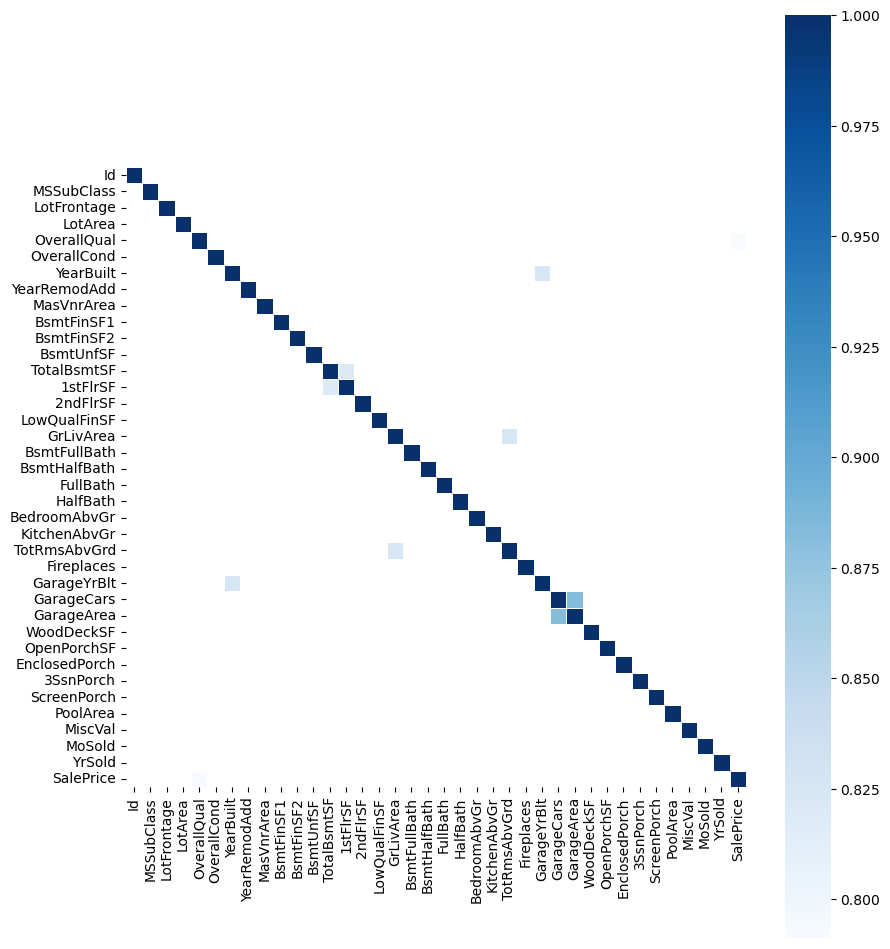

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


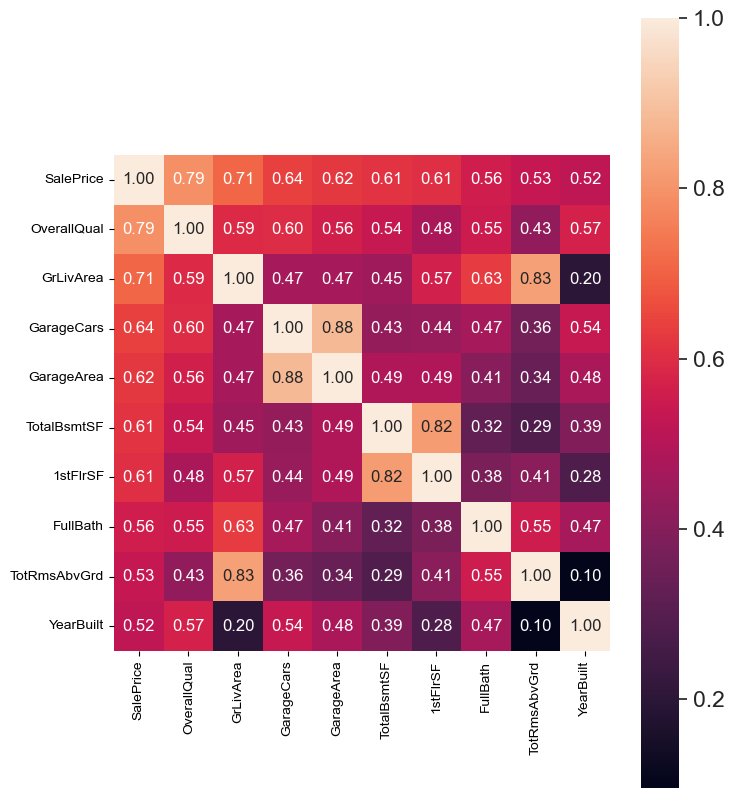

In [2]:
# ------------------------
# Reading data
# ------------------------
df_train=pd.read_csv('../input/train.csv')
df_test=pd.read_csv("../input/test.csv")

# ------------------------
# Quick correlation analysis
# ------------------------
corrmat=df_train.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(10,12))
sns.heatmap(corrmat,mask=corrmat<0.75,linewidth=0.5,cmap="Blues", square=True)
plt.show()

corrmat=df_train.corr(numeric_only=True)
print(corrmat['SalePrice'].sort_values(ascending=False).head(10))

k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
f, ax = plt.subplots(figsize=(8,10))
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 12}, yticklabels=cols.values,
                 xticklabels=cols.values)
plt.show()

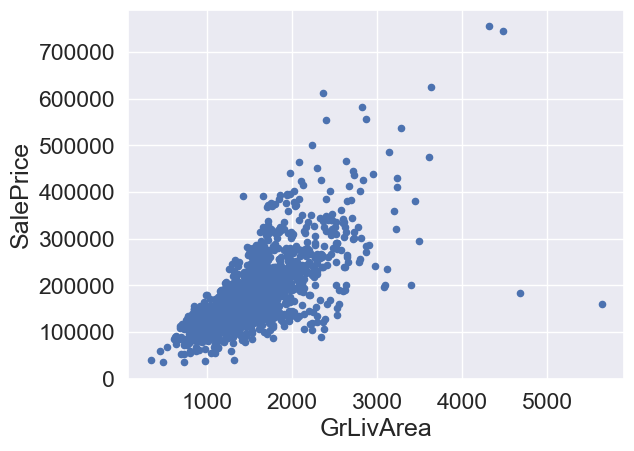

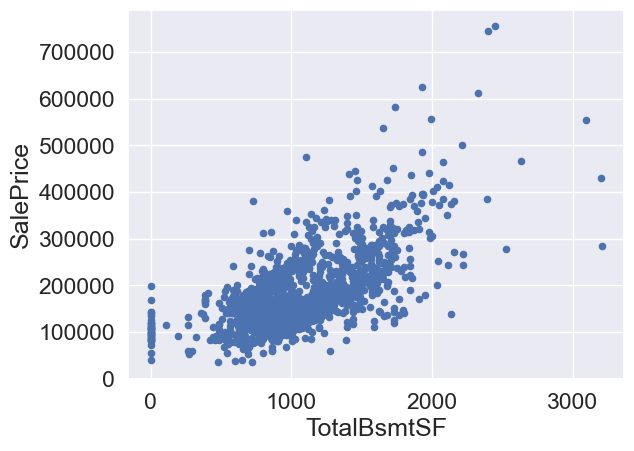

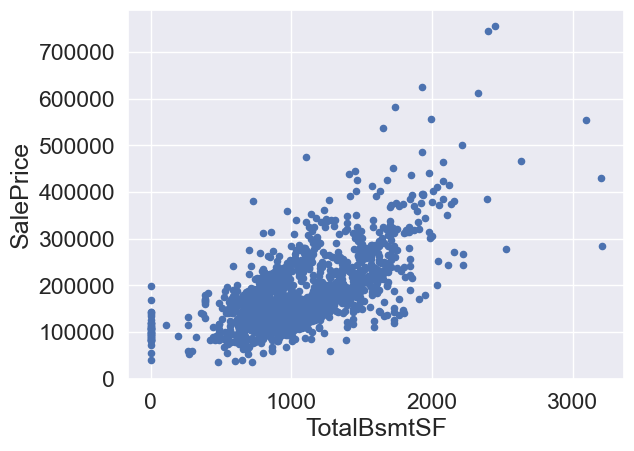

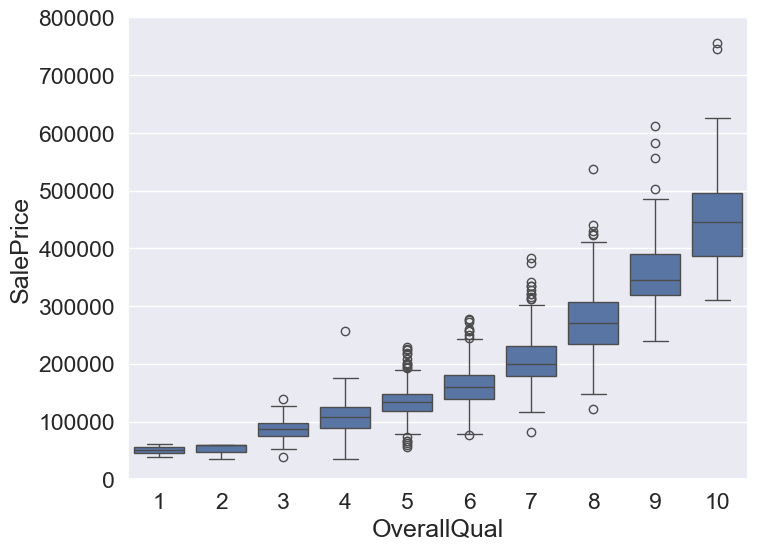

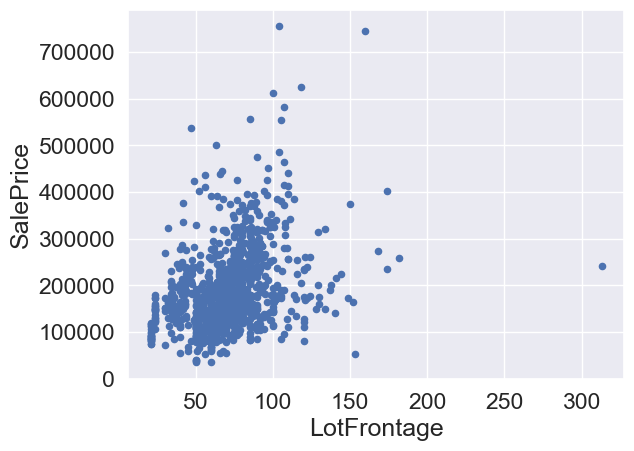

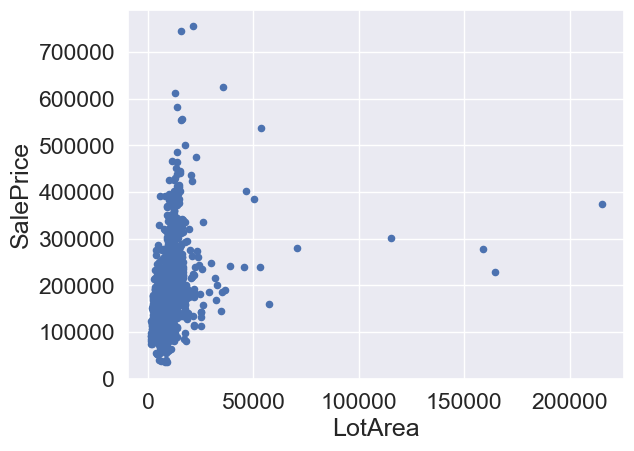

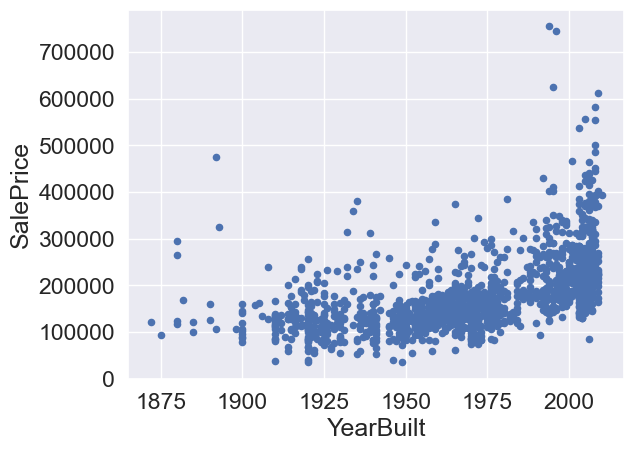

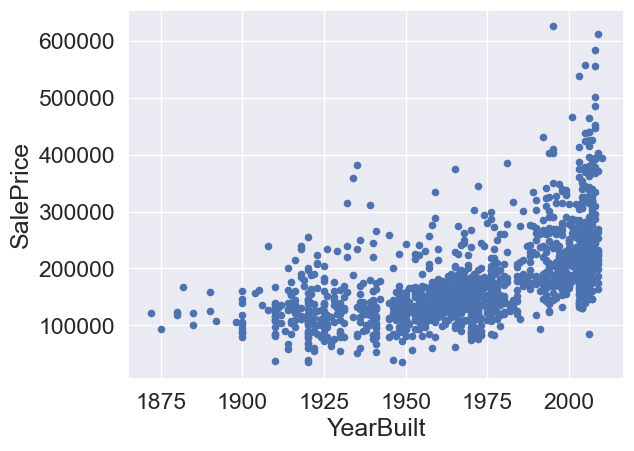

SalePrice       1.000000
OverallQual     0.800988
GrLivArea       0.717653
TotalBsmtSF     0.652983
GarageCars      0.648798
GarageArea      0.634539
1stFlrSF        0.627521
YearBuilt       0.562347
FullBath        0.560167
TotRmsAbvGrd    0.531342
Name: SalePrice, dtype: float64


In [3]:

# ------------------------
# Outlier removal
# ------------------------
df_train.plot.scatter(x='GrLivArea', y='SalePrice')
plt.show()

df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train=df_train.drop(df_train[df_train['Id']==1299].index)
df_train=df_train.drop(df_train[df_train['Id']==524].index)

df_train.plot.scatter(x='TotalBsmtSF', y='SalePrice')
plt.show()

df_train.sort_values(by='TotalBsmtSF',ascending=False)[:2]
df_train[df_train['TotalBsmtSF']>2000].sort_values(by='SalePrice',ascending=True)[:2]
df_train.drop(df_train[df_train['Id']==1224].index,inplace=True)
df_train.plot.scatter(x='TotalBsmtSF', y='SalePrice')
plt.show()

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x="OverallQual", y="SalePrice", data=df_train)
fig.axis(ymin=0, ymax=800000)
plt.show()

df_train.drop(df_train[(df_train.OverallQual==4) & (df_train.SalePrice>200000)].index,inplace=True)

df_train.plot.scatter(x='LotFrontage', y='SalePrice')
plt.show()

df_train.drop(df_train[df_train['LotFrontage'] > 200].index,inplace=True)

df_train.plot.scatter(x='LotArea', y='SalePrice')
plt.show()

df_train.plot.scatter(x='YearBuilt', y='SalePrice')
plt.show()

df_train.drop(df_train[(df_train.YearBuilt < 1900) & (df_train.SalePrice > 200000)].index,inplace=True)
df_train.drop(df_train[(df_train.YearBuilt < 2000) & (df_train.SalePrice > 650000)].index,inplace=True)
df_train.plot.scatter(x='YearBuilt', y='SalePrice')
plt.show()

corrmat1=df_train.corr(numeric_only=True)
print(corrmat1['SalePrice'].sort_values(ascending=False).head(10))

              Total   Percent
PoolQC         2900  0.997249
MiscFeature    2803  0.963893
Alley          2711  0.932256
Fence          2340  0.804677
MasVnrType     1759  0.604883
FireplaceQu    1419  0.487964
LotFrontage     485  0.166781
GarageQual      159  0.054677
GarageCond      159  0.054677
GarageYrBlt     159  0.054677
GarageFinish    159  0.054677
GarageType      157  0.053989
BsmtExposure     82  0.028198
BsmtCond         82  0.028198
BsmtQual         81  0.027854
BsmtFinType2     80  0.027510
BsmtFinType1     79  0.027166
MasVnrArea       23  0.007909
MSZoning          4  0.001376
BsmtFullBath      2  0.000688
BsmtHalfBath      2  0.000688
Functional        2  0.000688
Utilities         2  0.000688
BsmtUnfSF         1  0.000344
GarageArea        1  0.000344


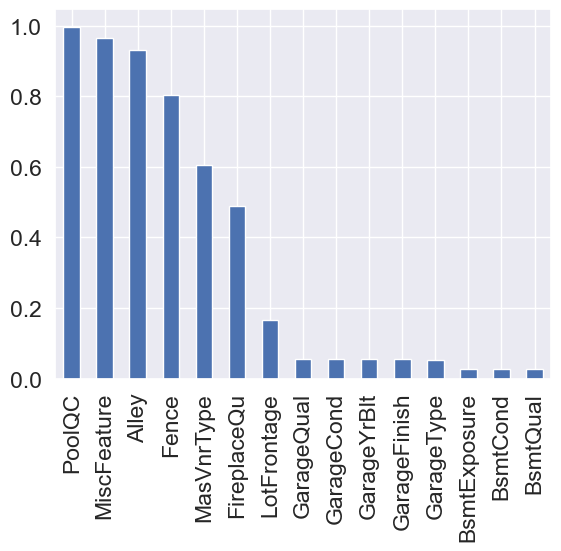

In [4]:

# ------------------------
# Concatenate train & test
# ------------------------
target=df_train['SalePrice'].reset_index(drop=True)
trainx=df_train.drop(['SalePrice'],axis=1)
all_features=pd.concat([trainx,df_test]).reset_index(drop=True)

# ------------------------
# Missing data analysis
# ------------------------
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(25))
missing_data['Percent'].head(15).plot.bar()
plt.show()


In [5]:

# ------------------------
# Imputing missing & basic transformations
# ------------------------
all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['GarageArea'] = all_features.groupby('Neighborhood')['GarageArea'].transform(lambda x: x.fillna(x.mean()))
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_features['YrSold'] = all_features['YrSold'].astype(str)
all_features['MoSold'] = all_features['MoSold'].astype(str)
all_features['Functional'] = all_features['Functional'].fillna('Typ')
all_features['Electrical'] = all_features['Electrical'].fillna("SBrkr")
all_features['KitchenQual'] = all_features['KitchenQual'].fillna("TA")
all_features['Exterior1st'] = all_features['Exterior1st'].fillna(all_features['Exterior1st'].mode()[0])
all_features['Exterior2nd'] = all_features['Exterior2nd'].fillna(all_features['Exterior2nd'].mode()[0])
all_features['SaleType'] = all_features['SaleType'].fillna(all_features['SaleType'].mode()[0])
all_features['MSZoning'] = all_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))






In [6]:
objects = []
for i in all_features.columns:
    if all_features[i].dtype == object:
        objects.append(i)
all_features.update(all_features[objects].fillna('None'))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)
all_features.update(all_features[numeric].fillna(0))

In [7]:
# ------------------------
# Feature engineering
# ------------------------
all_features['YearRemodAdd']=all_features['YearRemodAdd'].astype(int)
all_features['Years_Since_Remod'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
all_features['Age']=all_features['YrSold'].astype(int) - all_features['YearBuilt'].astype(int)
all_features['Newness']=all_features['Age']*all_features['Years_Since_Remod']
all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']

feats=['2ndFlrSF','GarageArea','TotalBsmtSF','Fireplaces','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']
for col  in feats:
    name='Has_'+str(col)
    all_features[name]=all_features[col].apply(lambda x: 1 if x > 0 else 0)

all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] 
                                  +all_features['EnclosedPorch'] + all_features['ScreenPorch'] 
                                  +all_features['WoodDeckSF'])

all_features['Bsmt_Baths'] = all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath'])
all_features['Total_BathAbvGrd'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']))
all_features['AvgRoomSize']=all_features['GrLivArea']/(all_features['TotRmsAbvGrd']+(0.4*all_features['Total_BathAbvGrd']))
all_features['BedBath']=all_features['BedroomAbvGr']*all_features['Total_BathAbvGrd']
all_features['TotalLot'] = all_features['LotFrontage'] + all_features['LotArea']
all_features['sqft_feet_living']=all_features['TotalBsmtSF']+all_features['GrLivArea']

all_features.drop(['Id','BsmtFullBath','BsmtHalfBath'],axis=1,inplace=True)

# Neighborhood mapping
neigh_map={'None': 0,'MeadowV':1,'IDOTRR':1,'BrDale':1,
           'OldTown':2,'Edwards':2,'BrkSide':2,
           'Sawyer':3,'Blueste':3,'SWISU':3,'NAmes':3,
           'NPkVill':4,'Mitchel':4,'SawyerW':4,
           'Gilbert':5,'NWAmes':5,'Blmngtn':5,
           'CollgCr':6,'ClearCr':6,'Crawfor':6,
           'Somerst':8,'Veenker':8,'Timber':8,
           'StoneBr':10,'NoRidge':10,'NridgHt':10 } 
all_features['Neighborhood'] = all_features['Neighborhood'].map(neigh_map)

# Quality maps
bsm_map = {'None': 0, 'Po': 1, 'Fa': 4, 'TA': 9, 'Gd': 16, 'Ex': 25}
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond','FireplaceQu']
for col in ord_col:
    all_features[col] = all_features[col].map(bsm_map)

# Fix year data
all_features.loc[2284,'Years_Since_Remod']=0
all_features.loc[2538,'Years_Since_Remod']=0
all_features.loc[2538,'Age']=0

# Drop highly collinear
all_features.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','LotFrontage'], axis=1, inplace=True)
# Drop features with huge missing
all_features.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)
# Drop less relevant
all_features.drop(['MoSold','YrSold'], axis=1, inplace=True)

# Drop features with >97% same values
overfit_cat = []
for i in all_features.columns:
    counts = all_features[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(all_features) * 100 > 97:
        overfit_cat.append(i)
overfit_cat=['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', '3SsnPorch', 'Has_TotalBsmtSF','Has_3SsnPorch']
all_features.drop(overfit_cat,axis=1,inplace=True)



In [9]:
# ------------------------
# Normalizing numeric features
# ------------------------

''''
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in all_features.columns:
    if all_features[i].dtype in numeric_dtypes:
        numeric.append(i)

skew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))

'''

"'\nnumeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']\nnumeric = []\nfor i in all_features.columns:\n    if all_features[i].dtype in numeric_dtypes:\n        numeric.append(i)\n\nskew_features = all_features[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)\nhigh_skew = skew_features[skew_features > 0.5]\nskew_index = high_skew.index\n\nfor i in skew_index:\n    all_features[i] = boxcox1p(all_features[i], boxcox_normmax(all_features[i] + 1))\n\n"

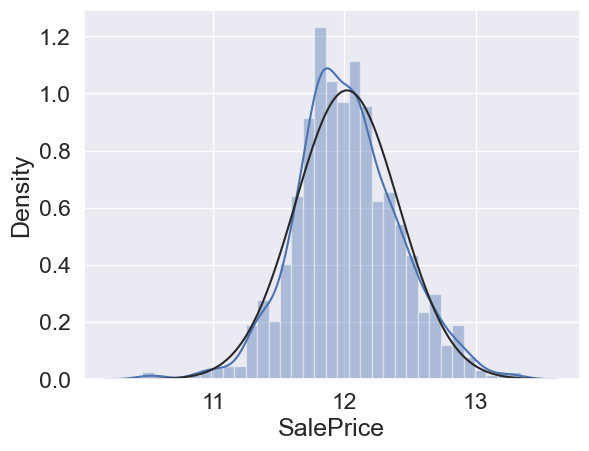

TypeError: can't multiply sequence by non-int of type 'str'

In [10]:
# ------------------------
# Transform target
# ------------------------
target = np.log1p(df_train['SalePrice']).reset_index(drop=True)
sns.distplot(target, fit=norm)
plt.show()

# ------------------------
# Additional feature transforms
# (logging, squaring, sqrt, etc.)
# ------------------------
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'FireplaceQu', 'GarageArea', 
                'OpenPorchSF', 'EnclosedPorch','ScreenPorch','Years_Since_Remod',
                'Newness','Total_Home_Quality','Total_porch_sf','AvgRoomSize',
                'TotalLot','sqft_feet_living','BsmtFinSF1','BedBath']

all_features1 = all_features.copy()
loged_features = logs(all_features.copy(), numeric)
all_features = logs(all_features, log_features)

feats=['2ndFlrSF','GarageArea','Fireplaces','WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch']
for col  in feats:
    name1='Has_'+str(col) + '_log'
    if name1 in loged_features.columns:
        loged_features.drop(name1,axis=1,inplace=True)

for o in ord_col:
    name=str(o)+'_log'
    if name in loged_features.columns:
        loged_features.drop(name,axis=1,inplace=True)

if 'Neighborhood_log' in loged_features.columns:
    loged_features.drop('Neighborhood_log',axis=1,inplace=True)

def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

sq_features = squares(all_features.copy(), list(all_features.columns))
log_sq_cols = squares(loged_features.copy(), list(loged_features.columns))

def sqrt(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.sqrt(res[l])).values)
        res.columns.values[m] = l + '_sqroot'
        m += 1
    return res 

def cube(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]**3).values)
        res.columns.values[m] = l + '_cube3'
        m += 1
    return res

root_features = sqrt(sq_features.copy(), list(sq_features.columns))
cube_features = cube(sq_features.copy(), list(sq_features.columns))
var_feats = cube(log_sq_cols.copy(), list(log_sq_cols.columns))
var_feats = sqrt(var_feats.copy(), list(log_sq_cols.columns))



In [ ]:
# ------------------------
# One-hot encoding
# ------------------------
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features1 = pd.get_dummies(all_features1).reset_index(drop=True)
loged_features = pd.get_dummies(loged_features).reset_index(drop=True)
cube_features = pd.get_dummies(cube_features).reset_index(drop=True)
var_feats = pd.get_dummies(var_feats).reset_index(drop=True)
log_sq_cols = pd.get_dummies(log_sq_cols).reset_index(drop=True)

def get_splits(all_features,target):
    df=pd.concat([all_features, target],axis=1)
    X_train=df.iloc[:len(target),:]
    X_test=all_features.iloc[len(target):,:]
    return X_train,X_test

def get_valid(df,target,valid_fraction=0.2):
    validrows=int(len(df)*valid_fraction)
    trains=df[:-validrows]
    valids=df[-validrows:]
    feature_col=df.columns.drop(target)
    return trains,valids,feature_col

X_train,X_test=get_splits(all_features,target)
train,valid,feature_col=get_valid(X_train,'SalePrice')

X_train0,X_test0=get_splits(all_features1,target)
train0,valid0,feature_col0=get_valid(X_train0,'SalePrice')

X_train1,X_test1=get_splits(log_sq_cols,target)
train1,valid1,feature_col1=get_valid(X_train1,'SalePrice')

X_tr, X_te=get_splits(var_feats,target)
feat_col=X_tr.columns.drop('SalePrice')

tr_log,te_log=get_splits(loged_features,target)
log_feats=tr_log.columns.drop('SalePrice')

corr1=X_tr.corr()
print(corr1["SalePrice"].sort_values(ascending=False).head(15))

best_columns=['sqft_feet_living','GarageArea_log_sq','Age','BedBath','AvgRoomSize_log_sq',
              'TotalLot_log_sq','Total_porch_sf_log_sq']

fig = plt.figure(figsize=(12,20))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)

for i, feature in enumerate(list(best_columns), 1):
    plt.subplot(len(list(best_columns)), 2, i)
    sns.scatterplot(x=feature, y='SalePrice', data=X_train)
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    plt.legend(loc='best', prop={'size': 10})
plt.show()

# ------------------------
# Models & CV
# ------------------------
from sklearn.linear_model import Lasso
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

kf = KFold(n_splits=12, random_state=7, shuffle=True)
def cv_rmse(model, X, target=target):
    rmse = np.sqrt(-cross_val_score(model, X, target, scoring="neg_mean_squared_error", cv=kf,n_jobs=-1))
    return (rmse)

# ------------------------
# Lasso for feature selection
# ------------------------
from sklearn.linear_model import LassoCV

X = X_train1[feature_col1]
y = target
alphas = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,5e-3,5e-2]
Xscaled=RobustScaler().fit_transform(X)
lassopipe = LassoCV(max_iter=1e7, alphas=alphas, random_state=42,n_jobs=-1)
clf=lassopipe.fit(Xscaled,y)
importance=np.abs(clf.coef_)
frame=pd.DataFrame(importance,index=feature_col1)
imps=frame.sort_values(by=0,ascending=False).index

# ------------------------
# Ridge model
# ------------------------
from sklearn.pipeline import Pipeline

alphas=np.linspace(1,stop=50)
pipe=Pipeline([('scaler',RobustScaler()),
               ('ridgemodel',RidgeCV(alphas=alphas, cv=None,store_cv_values=True ))])
model=pipe.fit(X_train1[feature_col1],target)
print('Alpha: %f'%model['ridgemodel'].alpha_)
print('Score: %f'%np.sqrt(-model['ridgemodel'].best_score_))

ridgepred=model.predict(X_test1[feature_col1])

# Trying different subset sizes
alphas=np.linspace(1,stop=50,num=50)
pipe=Pipeline([('scaler',RobustScaler()),
               ('ridgemodel',RidgeCV(alphas=alphas, cv=None,store_cv_values=True))])
numfeats=[298,290,280,275,270,260,250]
for n in numfeats:
    model=pipe.fit(X_train1[imps[:n]],target)
    print(n)
    print('Alpha: %f'%model['ridgemodel'].alpha_)
    print('Score: %f'%np.sqrt(-model['ridgemodel'].best_score_))
    print('')

model=pipe.fit(X_train1[imps[:280]],target)
ridgepred=model.predict(X_test1[imps[:280]])

# ------------------------
# LightGBM
# ------------------------
lightgbm = LGBMRegressor(objective='regression', 
                         num_leaves=5,
                         learning_rate=0.007,
                         n_estimators=3500,
                         max_bin=163,
                         bagging_fraction=0.35711,
                         bagging_freq=4,
                         bagging_seed=8,
                         feature_fraction=0.1294,
                         feature_fraction_seed=8,
                         min_data_in_leaf = 8,
                         verbose=-1,
                         random_state=42,
                         n_jobs=-1)

lightgbmod=lightgbm.fit(X_train[feature_col],target)
lightpred=lightgbmod.predict(X_test[feature_col])
print((np.sqrt(-cross_val_score(lightgbm, X_train[feature_col], target, 
                                scoring="neg_mean_squared_error", cv=5))).mean())

# ------------------------
# SVR
# ------------------------
svr = make_pipeline(RobustScaler(),
                    SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))
svrmodel=svr.fit(X_train[feature_col],target)
svrpred=svrmodel.predict(X_test[feature_col])
print((cv_rmse(svr,X_train[feature_col])).mean())

# ------------------------
# XGBoost & Stacking
# ------------------------
xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,
)
xgboo=xgboost.fit(X_train[feature_col],target)
xgboostpred=xgboo.predict(X_test[feature_col])

stack_gen = StackingCVRegressor(regressors=(lightgbm, pipe, svr, xgboost),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
stack=stack_gen.fit(np.array(X_train[feature_col]),np.array(target))
stackpreds=stack.predict(np.array(X_test[feature_col]))
print((cv_rmse(xgboost,X_train[feature_col])).mean())

# ------------------------
# Blended model
# ------------------------
def submission(preds,pred):
    submission=pd.read_csv("../input/home-data-for-ml-course/sample_submission.csv")
    submission.iloc[:,1] = np.floor(np.expm1(preds))

    q1 = submission['SalePrice'].quantile(0.0045)
    q2 = submission['SalePrice'].quantile(0.99)
    submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
    submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
    # Scale predictions slightly
    submission['SalePrice'] *= 1.001619
    submission.to_csv('%s mycsvfile.csv'%pred,index=False)

subm= (0.2 * lightpred)+(0.4 * ridgepred)+(0.1 * stackpreds)+(0.3*svrpred)
submission(subm,pred='blended1705')

# ------------------------
# Permutation Importance demonstration
# ------------------------
import eli5
from eli5.sklearn import PermutationImportance

fc1=all_features1.drop(['sqft_feet_living','Age','Newness','Years_Since_Remod',
                        'Total_Home_Quality','TotalLot','Total_porch_sf',
                        'Bsmt_Baths','Total_BathAbvGrd','AvgRoomSize','BedBath'],axis=1)
fc=fc1.columns

alphas=np.linspace(1,stop=50,num=50)
pipe0=Pipeline([('scaler',RobustScaler()), 
                ('ridgemodel',RidgeCV(alphas=alphas, cv=None,store_cv_values=True))])
model0=pipe0.fit(X_train0[fc],target)

perm0 = PermutationImportance(model0['ridgemodel'], random_state=1, cv=5).fit(X_train0[fc], target)
# eli5.show_weights(perm0, feature_names=X_train0[fc].columns.tolist())

pipe1=Pipeline([('scaler',RobustScaler()),
                ('ridgemodel',RidgeCV(alphas=alphas, cv=None,store_cv_values=True))])
x = X_train1[imps[:270]]
model1=pipe1.fit(x,target)
perm1 = PermutationImportance(model1['ridgemodel'], random_state=1,cv=5).fit(x, target)
# eli5.show_weights(perm1, feature_names =x.columns.tolist())

# ------------------------
# Example shap usage
# ------------------------
import shap
explainer = shap.LinearExplainer(model1['ridgemodel'], x)
shap_values = explainer.shap_values(x)
# shap.summary_plot(shap_values, x, max_display=6)

# Example for XGBoost + SHAP
# (requires supporting environment with shap & xgboost)
import xgboost
from sklearn.model_selection import train_test_split

xgb_full = xgboost.DMatrix(X_train[feature_col], label=target)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_train[feature_col], target, 
                                                        test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(Xg_train, label=yg_train)
xgb_test = xgboost.DMatrix(Xg_test, label=yg_test)
params = {
    'learning_rate':0.0139,
    'n_estimators':4500,
    'max_depth':4,
    'min_child_weight':0,
    'subsample':0.7968,
    'colsample_bytree':0.4064,
    'nthread':-1,
    'scale_pos_weight':2,
    'seed':42,
}

modelxg = xgboost.train(params, xgb_train, 4500, 
                        [(xgb_train, "train"),(xgb_test, "valid")], 
                        early_stopping_rounds=5, verbose_eval=25)

shap.initjs()
shap_values1 = shap.TreeExplainer(modelxg).shap_values(xgb_test)
# shap.summary_plot(shap_values1, xgb_test, max_display=12)